In [1]:

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import  matplotlib.pyplot as plt
from torch.utils.data import DataLoader

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  **Training Model**

In [2]:
#defining model

class NNmodel(nn.Module):
  def __init__(self):
    super(NNmodel,self).__init__()
    self.conv1=nn.Conv2d(1,10,5)
    self.maxpool=nn.functional.max_pool2d
    self.conv2=nn.Conv2d(10,20,5)
    self.conv2_drop=nn.Dropout2d()
    self.fc1=nn.Linear(320,50)
    self.fc2=nn.Linear(50,20)
  def forward(self,x):
    x=self.conv1(x)
    x=self.maxpool(x,2)
    x=nn.functional.relu(x)
    x=self.conv2(x)
    x=self.conv2_drop(x)
    x=self.maxpool(x,2)
    x=nn.functional.relu(x)
    x=nn.functional.dropout(x,training=self.training)
    x=x.view(-1,320)
    x=self.fc1(x)
    x=nn.functional.relu(x)
    x=self.fc2(x)
    return nn.functional.log_softmax(x,dim=1)

# model for adversarial training
model=NNmodel().to(device)
# model for standard training
model2=NNmodel().to(device)

## IMAGES PRINTING

In [3]:
#function to print images
def show_last_batch(images, labels, num_images=10):
    plt.figure(figsize=(28, 28))

    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.show()

## **FGSM Attack**

In [4]:
#loss function
loss=nn.CrossEntropyLoss()

#fgsm attack
def fgsm_attack(images,labels,model,eps):
    images=images.to(device)
    labels=labels.to(device)
    images.requires_grad=True
    outputs=model(images)
    model.zero_grad()
    cost=loss(outputs,labels).to(device)
    cost.backward()
    attack_images=images+eps*images.grad.sign()
    attack_images=torch.clamp(attack_images,0,1)
    return attack_images

## **Training and Testing functions**

In [5]:
#training function for Standard training
def train(model,device,train_loader,optimizer,epoch,eps):
    for batch_idx, (image, labels) in enumerate(train_loader):
      image,labels=image.to(device),labels.to(device)

      optimizer.zero_grad()
      image.requires_grad=True

      output=model(image)
      loss=nn.functional.nll_loss(output,labels)
      loss.backward()

      optimizer.step()


In [6]:
#training function for adversarial training
def adv_train(model,device,train_loader,optimizer,epoch,eps):
    for batch_idx, (image, labels) in enumerate(train_loader):
      image,labels=image.to(device),labels.to(device)

      optimizer.zero_grad()
      image.requires_grad=True

      output=model(image)
      loss=nn.functional.nll_loss(output,labels)
      loss.backward()

      perturbed_image=fgsm_attack(image,labels,model,eps)
      output=model(perturbed_image)

      loss_adv=nn.functional.nll_loss(output,labels)
      loss_adv.backward()

      optimizer.step()


In [7]:

import torch.nn.functional as F
last_images = None
last_labels = None
def test(model, device, test_loader, epsilon):
    correct = 0
    total=0;
    adv_examples = []
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, target,model,epsilon)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        total+=len(target)
        correct += final_pred.eq(target.view_as(final_pred)).sum().item()
        final_pred=final_pred.flatten()
        last_images = perturbed_data.cpu().detach().numpy()
        # print(last_images.shape)
        last_labels = final_pred.cpu().detach().numpy()

    print(total)
    final_acc = correct / float(total)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc*100))

    return last_images,last_labels

## **Training** **and** **Testing** **Phase**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4456638.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 130059.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 246139.45it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4939208.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Normal Training Results on adversarial attacks:
10000
Epsilon: 0.7	Test Accuracy = 4049 / 10000 = 40.489999999999995


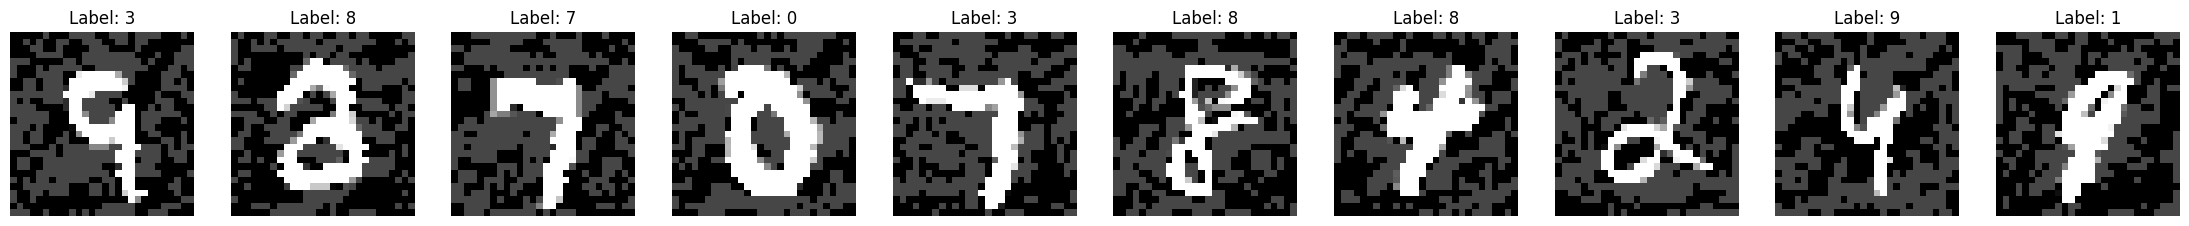

Adversarial Training Results on adversarial attacks:
10000
Epsilon: 0.7	Test Accuracy = 9658 / 10000 = 96.58


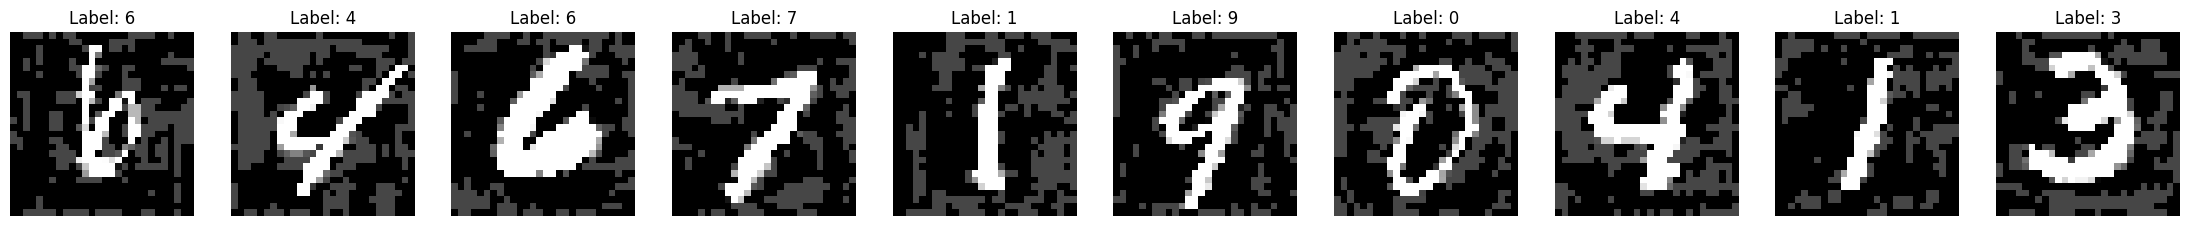

In [8]:
#training dataset
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

#testing dataset
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)


#optimizer for adversarial training
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer for standard training
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Epsilon value for FGSM
epsilon = 0.7
num_epochs = 5

# Standard Training
for epoch in range(1, num_epochs + 1):
    train(model2, device, train_loader, optimizer2, epoch, epsilon)
    # last_images,last_labels=test(model2, device, test_loader, epsilon)
    # show_last_batch(last_images, last_labels, num_images=10)
print("Normal Training Results on adversarial attacks:")
# # last_images = None
# # last_labels = None
last_images,last_labels=test(model2, device, test_loader, epsilon)



# Show images and labels from the last batch
show_last_batch(last_images, last_labels, num_images=10)

#Adversarial training
for epoch in range(1, num_epochs + 1):
    adv_train(model, device, train_loader, optimizer, epoch, epsilon)
    # last_images,last_labels=test(model, device, test_loader, epsilon)
    # show_last_batch(last_images, last_labels, num_images=10)

print("Adversarial Training Results on adversarial attacks:")
last_images,last_labels=test(model, device, test_loader, epsilon)
show_last_batch(last_images, last_labels, num_images=10)

## **CW** **Attack**

In [48]:
import torch.optim as optim

def f(x,kappa,targeted,labels) :
        outputs = model(x)
        labels = labels.to(device)
        # Create the identity matrix on the same device as labels
        one_hot_labels = torch.eye(len(outputs[0]), device=device)[labels]
        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        else :
             return torch.clamp(j-i, min=-kappa)


def cw_attack(model, images, labels, targeted=False, c=10, kappa=1, max_iter=1000, learning_rate=0.01) :
    images = images.to(device)
    labels = labels.to(device)
    w = torch.zeros_like(images, requires_grad=True).to(device)
    optimizer = optim.Adam([w], lr=learning_rate)
    prev = 1e10
    for i in range(max_iter) :
        image1 = 1/2*(nn.Tanh()(w) + 1)
        loss1 = nn.MSELoss(reduction='sum')(image1, images)
        loss2 = torch.sum(c*f(image1,kappa,targeted,labels))
        cost = loss1 + loss2
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        # print(i)
        # Early Stop when loss does not converge.
        if i % (max_iter//10) == 0 :
            if cost > prev :
                return image1
            prev = cost
    attack_images = 1/2*(nn.Tanh()(w) + 1)
    return attack_images


## **Testing against CW Attack**

Testing The Model against CW attack:
500
Epsilon: 0.7	Test Accuracy = 336 / 500 = 67.2


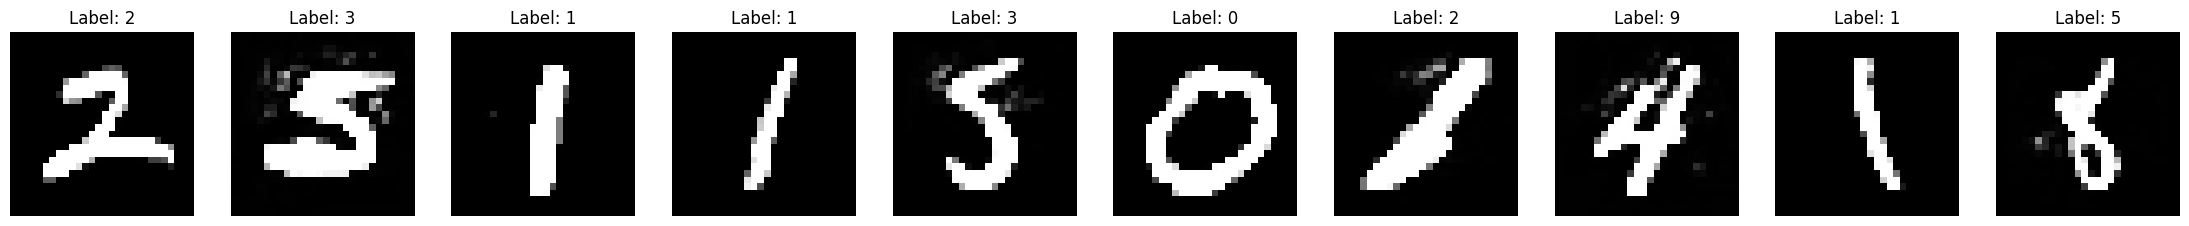

In [50]:
import torch.nn.functional as F
last_images = None
last_labels = None
def test_cw(model, device, test_loader, epsilon):
    correct = 0
    total=0;
    adv_examples = []
    model.eval()
    for i,(data, target) in enumerate(test_loader):
        if(i>49):
          break
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        perturbed_data = cw_attack(model ,data, target)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        total+=len(target)
        correct += final_pred.eq(target.view_as(final_pred)).sum().item()
        final_pred=final_pred.flatten()
        last_images = perturbed_data.cpu().detach().numpy()
        # print(last_images.shape)
        last_labels = final_pred.cpu().detach().numpy()

    print(total)
    final_acc = correct / float(total)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc*100))

    return last_images,last_labels


print("Testing The Model against CW attack:")
last_images,last_labels=test_cw(model, device, test_loader, epsilon)
show_last_batch(last_images, last_labels, num_images=10)

'''

T     uning the attack parameters can further decrrease the accuracy by a large extent

'''